In [1]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import deepxde as dde
dde.config.set_default_float('float64')
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
import re  # Importar o módulo 're' para manipulação de expressões regulares

# Verificar o backend ativo
print(f"Backend ativo: {dde.config.backend_name}")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64
Backend ativo: pytorch


In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Metaparameter, constants
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

U_REF = 0.005 # freeflow velocity in m/s, to normalize DNS data
L_REF = 1
MU  = 0.001 # in (Pa·s or Ns/m^2)
RHO = 998      # in kg/m**3
NU  = MU/RHO
P_REF = RHO * U_REF**2  # Reference Pressure (ρ * U_ref^2)

PERCENT = 0.02 #Percentage CFD data used for Supervised Learning
N_NEIGHBORS=20
BETA=0.5

# Training parameter
NUM_DOMAIN = 1000
NUM_BOUNDARY = 1000
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
#LOSS_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1]

# Setup Neural Net dimensions
HIDDEN_LAYER = 6
NEURONS = 100
INPUT_DIM = 2    # x, y
OUTPUT_DIM = 6   # (u, v, p, u'u', u'v', v'v')
LAYER_SIZE = [INPUT_DIM] + [NEURONS] * HIDDEN_LAYER + [OUTPUT_DIM]

# filepaths
file_path='TJUNCTIONNODES.cgns'

In [3]:
# Function to normalize data using reference values
def normalize_reference(data, reference_value):
    """
    Normalizes the data by dividing it by the reference value.
    
    Args:
        data (np.ndarray): Data to be normalized.
        reference_value (float): Reference value for normalization.
    
    Returns:
        np.ndarray: Normalized data.
    """
    return data / reference_value

# Function to denormalize data using reference values
def denormalize_reference(data, reference_value):
    """
    Denormalizes the data by multiplying it by the reference value.
    
    Args:
        data (np.ndarray): Normalized data.
        reference_value (float): Reference value for denormalization.
    
    Returns:
        np.ndarray: Denormalized data.
    """
    return data * reference_value

# Function to extract data from the CGNS file and apply normalization with reference values
def extract_and_normalize(file_path):
    with h5py.File(file_path, 'r') as f:
        # Extract coordinates
        grid_coords = f['Base/Zone/GridCoordinates']
        x_coords = grid_coords['CoordinateX/ data'][:]
        y_coords = grid_coords['CoordinateY/ data'][:]

        # Extract global solutions (velocities and pressure)
        solution_data = f['Base/Zone/FlowSolution.N:1']
        velocity_x = solution_data['VelocityX/ data'][:]
        velocity_y = solution_data['VelocityY/ data'][:]
        pressure = solution_data['Pressure/ data'][:]

        # Normalize using the reference values
        velocity_x_norm = normalize_reference(velocity_x, U_REF)
        velocity_y_norm = normalize_reference(velocity_y, U_REF)
        pressure_norm = normalize_reference(pressure, P_REF)

        # Store normalization parameters
        normalization_params = {
            "U_REF": U_REF,
            "P_REF": P_REF,
            "L_REF": L_REF
        }

        # Process specific zones
        zones_of_interest = ['interior-surface_body', 'inlet', 'outlet1', 'outlet2', 'wall-surface_body'] #Just "outlet" for sudden expansion
        zone_data = {}

        for zone in zones_of_interest:
            try:
                # Get element connectivity of the zone
                element_connectivity = f[f'Base/Zone/{zone}/ElementConnectivity/ data'][:]
                unique_node_ids = np.unique(element_connectivity).astype(int)

                valid_indices = unique_node_ids - 1
                valid_indices = valid_indices[(valid_indices >= 0) & (valid_indices < len(x_coords))]

                # Organize normalized data
                zone_data[zone] = {
                    'x_coords': normalize_reference(x_coords[valid_indices], L_REF),
                    'y_coords': normalize_reference(y_coords[valid_indices], L_REF),
                    'velocity_x': velocity_x_norm[valid_indices],
                    'velocity_y': velocity_y_norm[valid_indices],
                    'pressure': pressure_norm[valid_indices]
                }
            except KeyError as e:
                print(f"Error accessing zone {zone}: {e}")

        return zone_data, normalization_params


In [4]:
def load_training_data_from_zones(selected_zone=None, num_points_per_zone=None):
    """
    Unified function to load data from a specific zone or from all available zones.
    If 'num_points_per_zone' is None, all available points in the zone will be loaded.
    If 'num_points_per_zone' is specified, random sampling will be applied.

    Args:
        selected_zone (str): Name of the zone to be loaded.
                             If None, all available zones will be loaded.
        num_points_per_zone (int): Number of points to be sampled.

    Returns:
        x_train, y_train, u_train, v_train, p_train, normalization_params
    """
    zone_data, normalization_params = extract_and_normalize(file_path)

    selected_data = []

    if selected_zone:
        if selected_zone in zone_data:
            data = zone_data[selected_zone]
            total_points = len(data['x_coords'])
            
            # Select all points if num_points_per_zone is None
            if num_points_per_zone is None:
                indices = np.arange(total_points)  # All indices
            else:
                num_points = min(num_points_per_zone, total_points)
                indices = np.random.choice(total_points, num_points, replace=False)
            
            x = data['x_coords'][indices][:, None]
            y = data['y_coords'][indices][:, None]
            u = data['velocity_x'][indices][:, None]
            v = data['velocity_y'][indices][:, None]
            p = data['pressure'][indices][:, None]
            
            return [x, y, u, v, p, normalization_params]
        else:
            print(f"Zone '{selected_zone}' not found in the available data.")
            return None
    else:
        for zone, data in zone_data.items():
            total_points = len(data['x_coords'])

            if num_points_per_zone is None:
                indices = np.arange(total_points)  # All indices
            else:
                num_points = min(num_points_per_zone, total_points)
                indices = np.random.choice(total_points, num_points, replace=False)

            x = data['x_coords'][indices][:, None]
            y = data['y_coords'][indices][:, None]
            u = data['velocity_x'][indices][:, None]
            v = data['velocity_y'][indices][:, None]
            p = data['pressure'][indices][:, None]

            zone_selected_data = np.concatenate([x, y, u, v, p], axis=1)
            selected_data.append(zone_selected_data)

        selected_data = np.concatenate(selected_data, axis=0)

    x_train = selected_data[:, 0:1]
    y_train = selected_data[:, 1:2]
    u_train = selected_data[:, 2:3]
    v_train = selected_data[:, 3:4]
    p_train = selected_data[:, 4:5]

    return [x_train, y_train, u_train, v_train, p_train, normalization_params]


In [5]:
def load_training_data_with_gradient_based_decoupled_supervision(
    selected_zone="interior-surface_body",
    percent=PERCENT,
    n_neighbors=N_NEIGHBORS,
    sampling="top",  # "top" ou "weighted"
    beta=1.0,         # apenas usado se sampling="weighted"
    seed=1            # garante reprodutibilidade se sampling="weighted"
):
    """
    Seleciona sensores baseados em gradientes (por variável), com opção de amostragem ponderada ("weighted") ou por top X% ("top").

    Args:
        selected_zone (str): Zona a usar (por padrão, 'interior-surface_body').
        percent (float): Percentagem de pontos a selecionar.
        n_neighbors (int): Número de vizinhos para regressão local.
        sampling (str): Estratégia de seleção ("top" ou "weighted").
        beta (float): Peso de sensibilidade para amostragem ponderada.
        seed (int): Semente aleatória para reprodutibilidade (usado em "weighted").

    Returns:
        Lista com: [xy_u, u_values, xy_v, v_values, xy_p, p_values, normalization_params]
    """
    import matplotlib.pyplot as plt
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    zone_data, normalization_params = extract_and_normalize(file_path)
    if selected_zone not in zone_data:
        print(f"Zone '{selected_zone}' not found.")
        return [None] * 7

    data = zone_data[selected_zone]
    x_all = data['x_coords']
    y_all = data['y_coords']
    coords = np.column_stack((x_all, y_all))
    N = len(coords)
    num_selected = max(1, int(percent * N))

    def process_variable(values, varname, unidade):
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        neigh.fit(coords)
        _, indices = neigh.kneighbors(coords)

        grad_mag = np.zeros(N)
        for i, neighbors in enumerate(indices):
            neighbor_coords = coords[neighbors]
            neighbor_vals = values[neighbors]
            A = np.c_[neighbor_coords[:, 0], neighbor_coords[:, 1], np.ones(len(neighbors))]
            coeffs, *_ = np.linalg.lstsq(A, neighbor_vals, rcond=None)
            grad_mag[i] = np.sqrt(coeffs[0]**2 + coeffs[1]**2)

        # Estatísticas
        p99 = np.percentile(grad_mag, 98)
        print(f"\n🔍 Gradient stats for {varname.upper()} ({unidade}):")
        print(f"  Mean:    {np.mean(grad_mag):.4f}")
        print(f"  Median:  {np.median(grad_mag):.4f}")
        print(f"  Max:     {np.max(grad_mag):.4f}")
        print(f"  99th pct: {p99:.4f}")
        print(f"  # points with grad > p99: {(grad_mag > p99).sum()}")

        # Histograma
        plt.figure(figsize=(8, 4))
        plt.hist(grad_mag, bins=100, color="steelblue", edgecolor="black")
        plt.title(f"Gradient distribution |∇{varname}| ({unidade})")
        plt.xlabel(f"|∇{varname}|")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Mapa
        plt.figure(figsize=(10, 8))
        sc = plt.scatter(coords[:, 0], coords[:, 1], c=np.clip(grad_mag, 0, p99),
                         cmap="inferno", s=10)
        plt.colorbar(sc, label=f"|∇{varname}| (clipped at 99th pct: {p99:.2f})")
        plt.title(f"Gradient map of |∇{varname}|")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.gca().set_aspect("equal")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        if sampling == "top":
            top_indices = np.argsort(-grad_mag)[:num_selected]
        elif sampling == "weighted":
            np.random.seed(seed)
            grad_pow = grad_mag ** beta
            probabilities = grad_pow / np.sum(grad_pow)
            top_indices = np.random.choice(np.arange(N), size=num_selected, replace=False, p=probabilities)
        else:
            raise ValueError("sampling must be 'top' or 'weighted'.")

        x_sel = x_all[top_indices][:, None]
        y_sel = y_all[top_indices][:, None]
        v_sel = values[top_indices][:, None]
        xy_sel = np.hstack((x_sel, y_sel))
        return xy_sel, v_sel

    xy_u, u_values = process_variable(data['velocity_x'], "u", "adim (u/U_REF)/m")
    xy_v, v_values = process_variable(data['velocity_y'], "v", "adim (v/U_REF)/m")
    xy_p, p_values = process_variable(data['pressure'],    "p",    "adim (p/P_REF)/m")

    return [xy_u, u_values, xy_v, v_values, xy_p, p_values, normalization_params]


Number of available points per zone:

Zone: interior-surface_body - 4357 points available
Zone: inlet - 28 points available
Zone: outlet1 - 20 points available
Zone: outlet2 - 19 points available
Zone: wall-surface_body - 379 points available


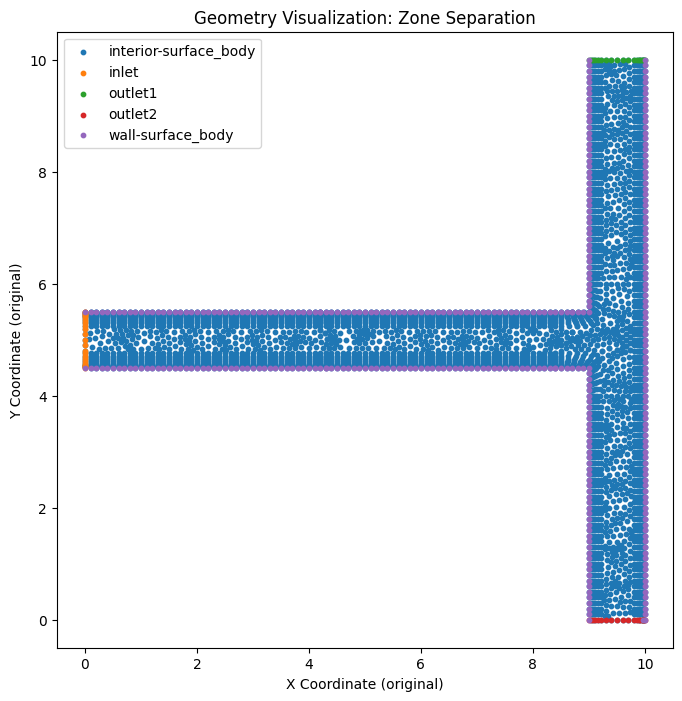

In [6]:
def visualize_geometry(zone_data):
    plt.figure(figsize=(8, 8))

    # Plot the points of each zone using different colors
    for zone, data in zone_data.items():
        x_coords = data['x_coords']  # X coordinates (not normalized)
        y_coords = data['y_coords']  # Y coordinates (not normalized)
        plt.scatter(x_coords, y_coords, label=f'{zone}', s=10)

    plt.title('Geometry Visualization: Zone Separation')
    plt.xlabel('X Coordinate (original)')
    plt.ylabel('Y Coordinate (original)')
    plt.legend()

    # Adjust the aspect ratio so that X and Y have equal scale
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()

# Function to count the number of available points in each zone
def check_number_of_points(zone_data):
    print("Number of available points per zone:\n")
    for zone, data in zone_data.items():
        num_points = len(data['x_coords'])
        print(f"Zone: {zone} - {num_points} points available")

# Call the function to extract the data and normalize only velocity and pressure
zone_data, normalization_params = extract_and_normalize(file_path)  # Also returns the normalization parameters

# Check number of points per zone
check_number_of_points(zone_data)

# Visualize geometry (coordinates not normalized)
visualize_geometry(zone_data)



🔍 Gradient stats for U (adim (u/U_REF)/m):
  Mean:    2.5203
  Median:  0.4445
  Max:     11.0168
  99th pct: 9.3049
  # points with grad > p99: 88


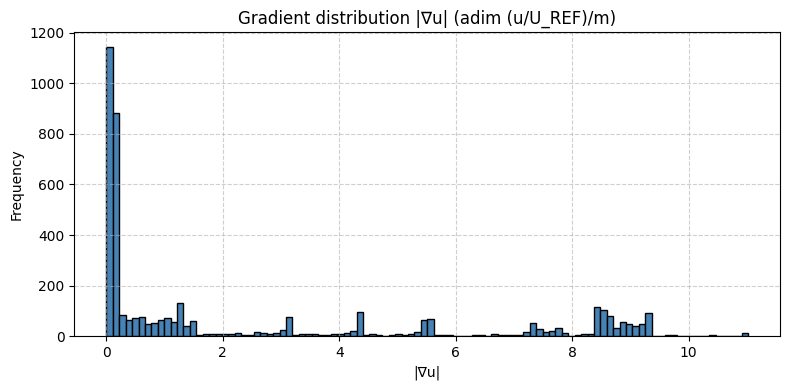

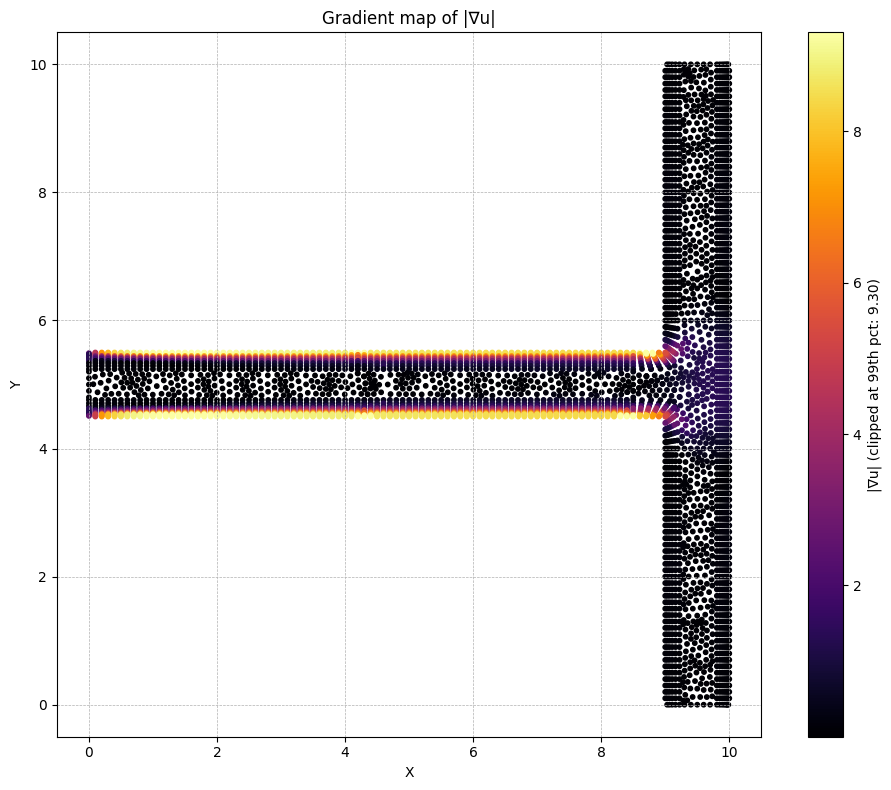


🔍 Gradient stats for V (adim (v/U_REF)/m):
  Mean:    1.0551
  Median:  0.0872
  Max:     7.2769
  99th pct: 7.0143
  # points with grad > p99: 88


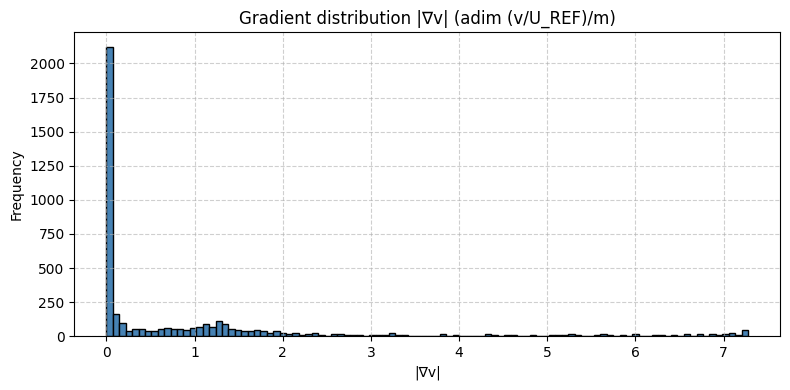

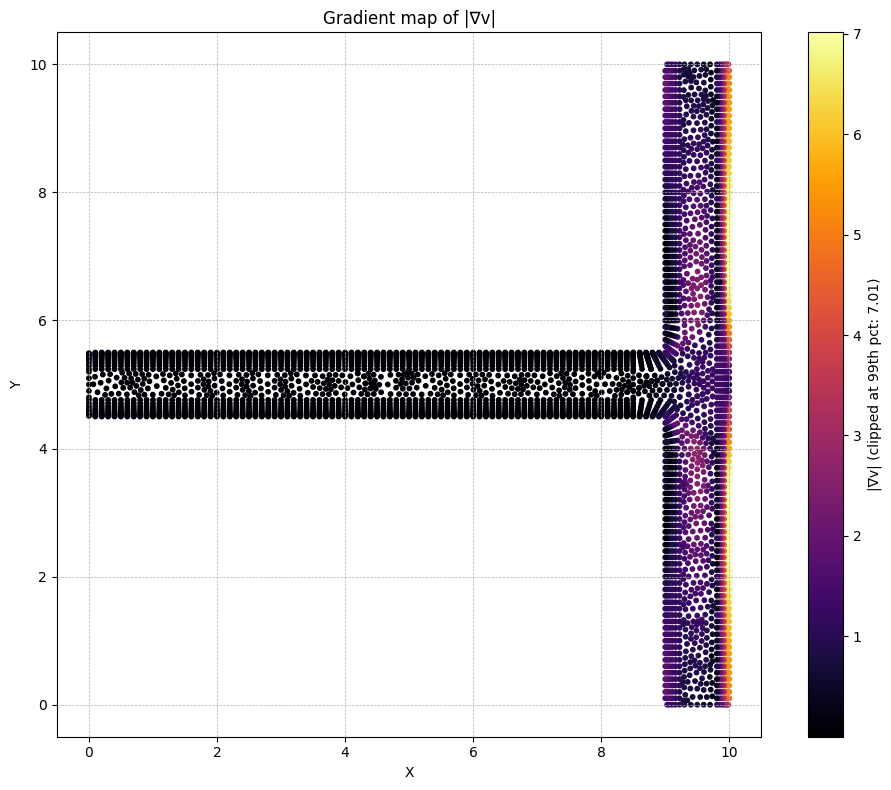


🔍 Gradient stats for P (adim (p/P_REF)/m):
  Mean:    0.1035
  Median:  0.0271
  Max:     1.2406
  99th pct: 0.8499
  # points with grad > p99: 88


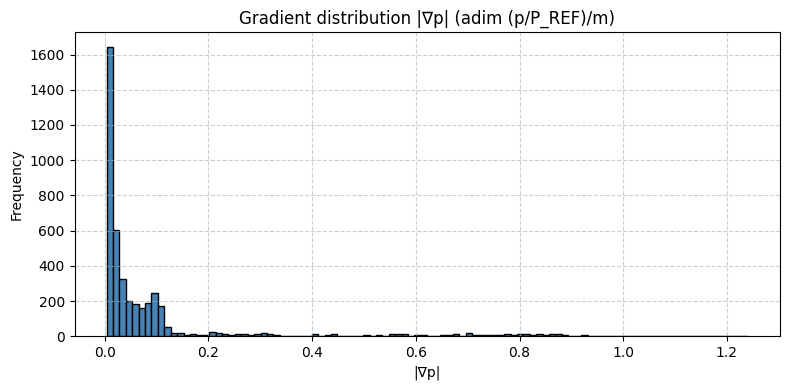

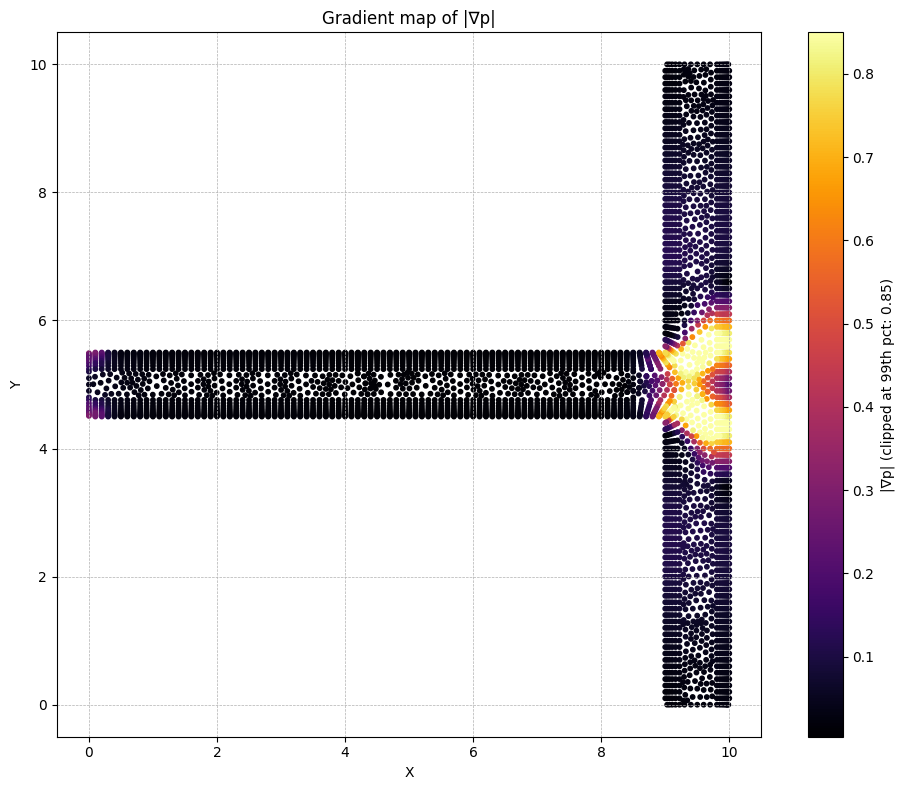

In [7]:
zone_data, normalization_params = extract_and_normalize(file_path)

[xy_u_interior, u_values_interior, xy_v_interior, v_values_interior, xy_p_interior, p_values_interior, normalization_params_interior] = load_training_data_with_gradient_based_decoupled_supervision(
    selected_zone="interior-surface_body",
    percent=PERCENT,
    sampling="weighted",
    beta=BETA,
    seed=3
)


# Coordinates and supervised values from the interior
interior_u_coords, interior_u_values = xy_u_interior, u_values_interior
interior_v_coords, interior_v_values = xy_v_interior, v_values_interior
interior_p_coords, interior_p_values = xy_p_interior, p_values_interior

# Extract boundary data
[x_train_inlet, y_train_inlet, u_train_inlet, v_train_inlet, p_train_inlet, normalization_params_inlet] = load_training_data_from_zones(selected_zone='inlet', num_points_per_zone=None)
[x_train_outlet1, y_train_outlet1, u_train_outlet1, v_train_outlet1, p_train_outlet1, normalization_params_outlet1] = load_training_data_from_zones(selected_zone='outlet1', num_points_per_zone=None)
[x_train_outlet2, y_train_outlet2, u_train_outlet2, v_train_outlet2, p_train_outlet2, normalization_params_outlet2] = load_training_data_from_zones(selected_zone='outlet2', num_points_per_zone=None)
[x_train_walls, y_train_walls, u_train_walls, v_train_walls, p_train_walls, normalization_params_walls] = load_training_data_from_zones(selected_zone='wall-surface_body', num_points_per_zone=None)

# Combine data from boundary zones
boundary_coordinates = np.vstack((
    np.column_stack((x_train_inlet, y_train_inlet)),
    np.column_stack((x_train_outlet1, y_train_outlet1)),
    np.column_stack((x_train_outlet2, y_train_outlet2)),
    np.column_stack((x_train_walls, y_train_walls))
))

boundary_u_values = np.concatenate((u_train_inlet, u_train_outlet1, u_train_outlet2, u_train_walls))
boundary_v_values = np.concatenate((v_train_inlet, v_train_outlet1, v_train_outlet2, v_train_walls))
boundary_p_values = np.concatenate((p_train_inlet, p_train_outlet1, p_train_outlet2, p_train_walls))

# List of boundary conditions separated by region
boundary_conditions = [
    # Inlet
    dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), u_train_inlet, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), v_train_inlet, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), p_train_inlet, component=2),

    # Outlet 1
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), u_train_outlet1, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), v_train_outlet1, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), p_train_outlet1, component=2),

    # Outlet 2
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), u_train_outlet2, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), v_train_outlet2, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), p_train_outlet2, component=2),

    # Walls
    dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), u_train_walls, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), v_train_walls, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), p_train_walls, component=2),
]

# Combine all supervised coordinates from the interior and boundaries
all_xy = np.vstack((interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates))

# Define the geometry using the domain coordinates
#geom = dde.geometry.PointCloud(points=np.vstack((interior_u_coords, interior_v_coords, interior_p_coords)),boundary_points=boundary_coordinates)
geom = dde.geometry.geometry_2d.Polygon([[0, 4.5], [0, 5.5], [9, 5.5], [9, 10], [10, 10],[10, 0],[9, 0],[9, 4.5]])

# Define observation conditions for variables u, v and p
observe_u = dde.icbc.PointSetBC(interior_u_coords, interior_u_values, component=0)
observe_v = dde.icbc.PointSetBC(interior_v_coords, interior_v_values, component=1)
observe_p = dde.icbc.PointSetBC(interior_p_coords, interior_p_values, component=2)

#wall_u = dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), [0.0], component=0)
#wall_v = dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), [0.0], component=1)

#walls = [wall_u, wall_v]


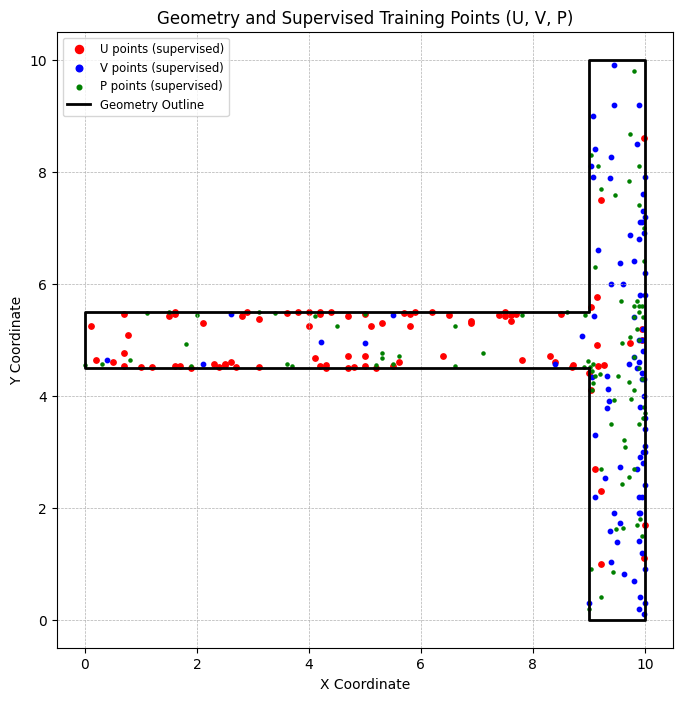

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training_points(interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates, geom):
    """
    Visualize the geometry and the training points for U, V, and P within the domain.
    The geometry is outlined with a solid black line using the vertices from the Polygon.
    
    Args:
        interior_u_coords (ndarray): Coordinates of supervised U points.
        interior_v_coords (ndarray): Coordinates of supervised V points.
        interior_p_coords (ndarray): Coordinates of supervised P points.
        boundary_coordinates (ndarray): Coordinates of boundary points (optional, may not be used in this version).
        geom (Polygon): The geometry of the domain as a DeepXDE polygon.
    """
    plt.figure(figsize=(10, 8))

    # Plot U, V, and P training points inside the domain with distinct colors
    plt.scatter(interior_u_coords[:, 0], interior_u_coords[:, 1], color='red', s=15, label='U points (supervised)')
    plt.scatter(interior_v_coords[:, 0], interior_v_coords[:, 1], color='blue', s=10, label='V points (supervised)')
    plt.scatter(interior_p_coords[:, 0], interior_p_coords[:, 1], color='green', s=5, label='P points (supervised)')

    # Extract the vertices of the polygon to draw the geometry outline
    polygon_vertices = np.array(geom.vertices)  # Extract vertices from the Polygon
    polygon_vertices = np.vstack((polygon_vertices, polygon_vertices[0]))  # Close the loop of the polygon
    plt.plot(polygon_vertices[:, 0], polygon_vertices[:, 1], color='black', linewidth=2, label='Geometry Outline')

    plt.title('Geometry and Supervised Training Points (U, V, P)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', fontsize='small', markerscale=1.5)
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain equal aspect ratio for x and y
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


# Example of how to call the function
visualize_training_points(interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates, geom)


In [9]:
# Part 2 - PINN Model (RANS with Reynolds Stress Tensor)

def RANS_Equations_Dimensionless(x, y):
    Re = (RHO * U_REF * L_REF) / MU  # Reynolds number

    # Dimensionless variables
    u = y[:, 0:1]  # Dimensionless velocity in the x-direction
    v = y[:, 1:2]  # Dimensionless velocity in the y-direction
    p = y[:, 2:3]  # Dimensionless pressure
    uu_reynolds = y[:, 3:4]  # Dimensionless Reynolds stress: u'u'
    uv_reynolds = y[:, 4:5]  # Dimensionless Reynolds stress: u'v'
    vv_reynolds = y[:, 5:6]  # Dimensionless Reynolds stress: v'v'

    # Dimensionless derivatives
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)
    duu_dx = dde.grad.jacobian(y, x, i=3, j=0)
    duv_dy = dde.grad.jacobian(y, x, i=4, j=1)
    duv_dx = dde.grad.jacobian(y, x, i=4, j=0)
    dvv_dy = dde.grad.jacobian(y, x, i=5, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # Dimensionless RANS equations
    continuity = du_dx + dv_dy
    x_momentum = (u * du_dx + v * du_dy + dp_dx - (1 / Re) * (du_xx + du_yy) - duu_dx - duv_dy)
    y_momentum = (u * dv_dx + v * dv_dy + dp_dy - (1 / Re) * (dv_xx + dv_yy) - duv_dx - dvv_dy)

    return [continuity, x_momentum, y_momentum]

# Define the data for the PINN model
data = dde.data.PDE(
    geom,
    RANS_Equations_Dimensionless,
    [*boundary_conditions, observe_u, observe_v, observe_p],  # Observers (u, v, p inside + boundary)
    num_domain=NUM_DOMAIN,  # Collocation points in the interior
    num_boundary=NUM_BOUNDARY,  # Boundary points
    #train_distribution="LHS",
    anchors=all_xy  # All supervised points combined
)

# Configure the neural network (PINN)
layer_size = [INPUT_DIM] + [NEURONS] * HIDDEN_LAYER + [OUTPUT_DIM]  # 2 inputs (x, y) and 6 outputs (u, v, p, u'u', u'v', v'v')
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(LAYER_SIZE, ACTIVATION, INITIALIZER)

# Create the PINN model
model = dde.Model(data, net)

# Configure early stopping
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=10000)
model.compile("L-BFGS")

# Carregar o modelo salvo
model.restore("8.0.4.ckpt-54000.pt", verbose=1)


Compiling model...
'compile' took 0.645662 s

Restoring model from 8.0.4.ckpt-54000.pt ...



C:\Users\d3449\AppData\Roaming\Python\Python310\site-packages\deepxde\model.py:1096: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


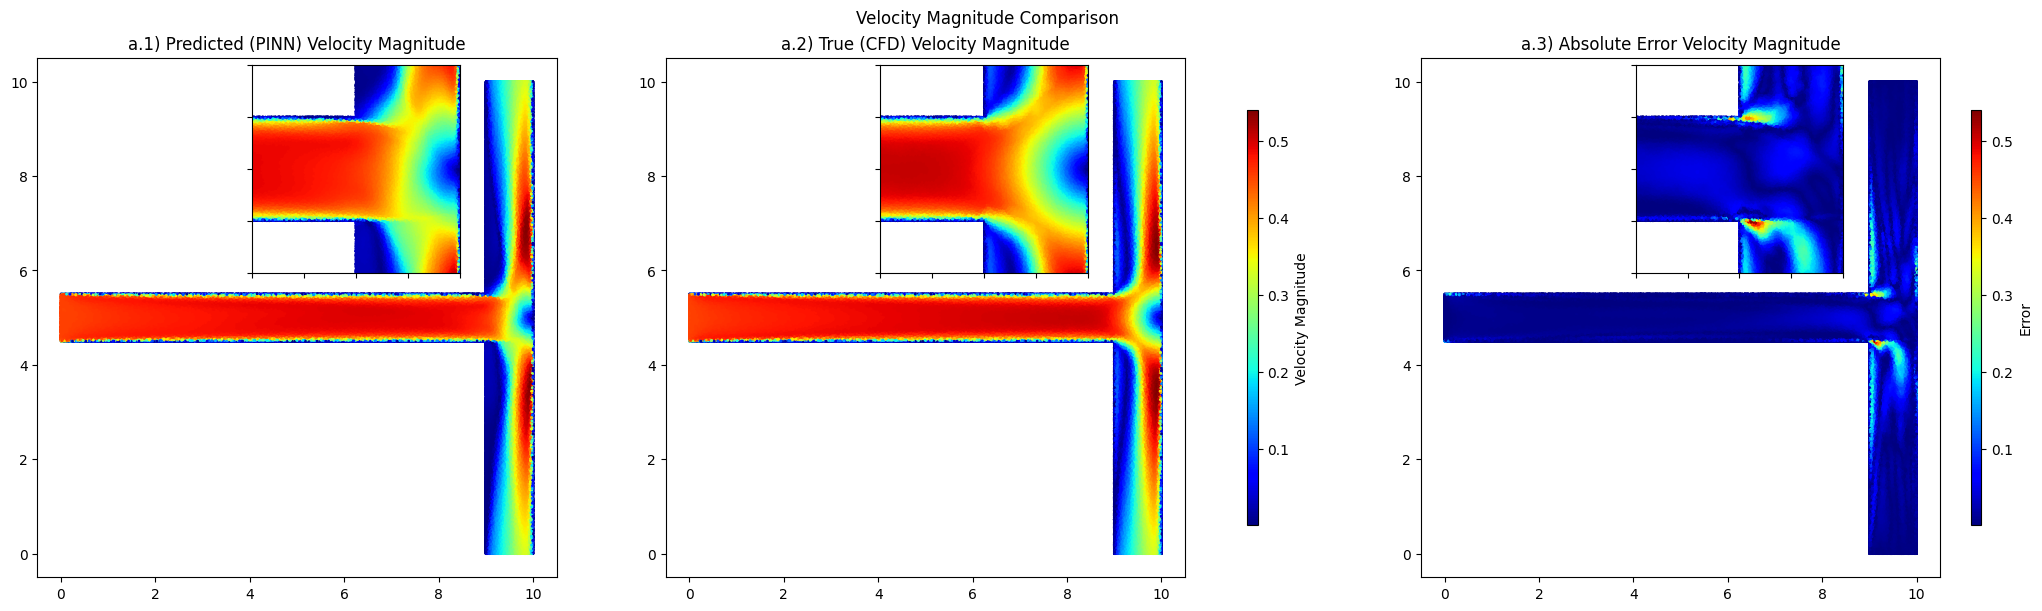

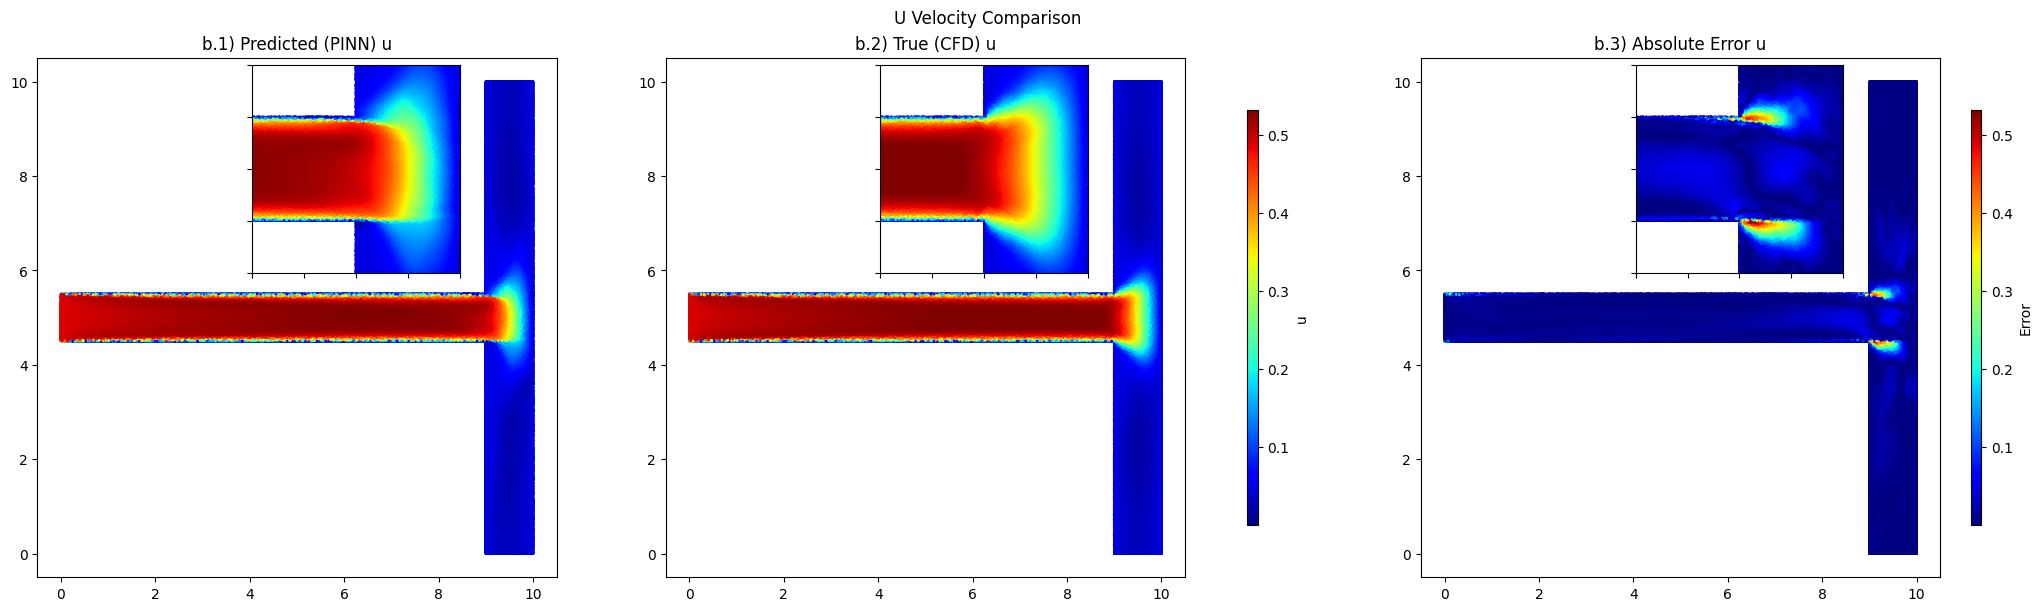

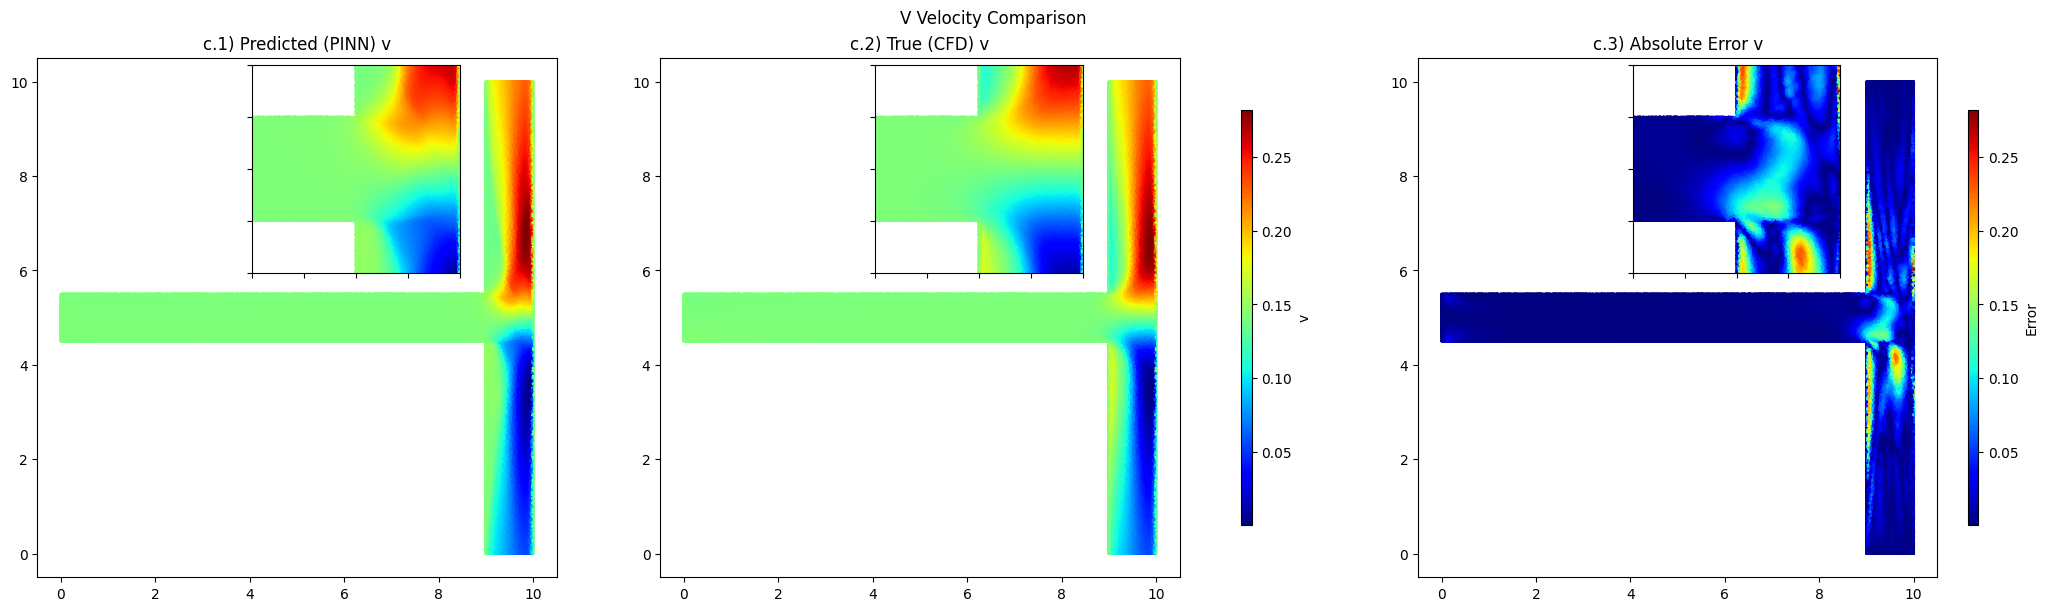

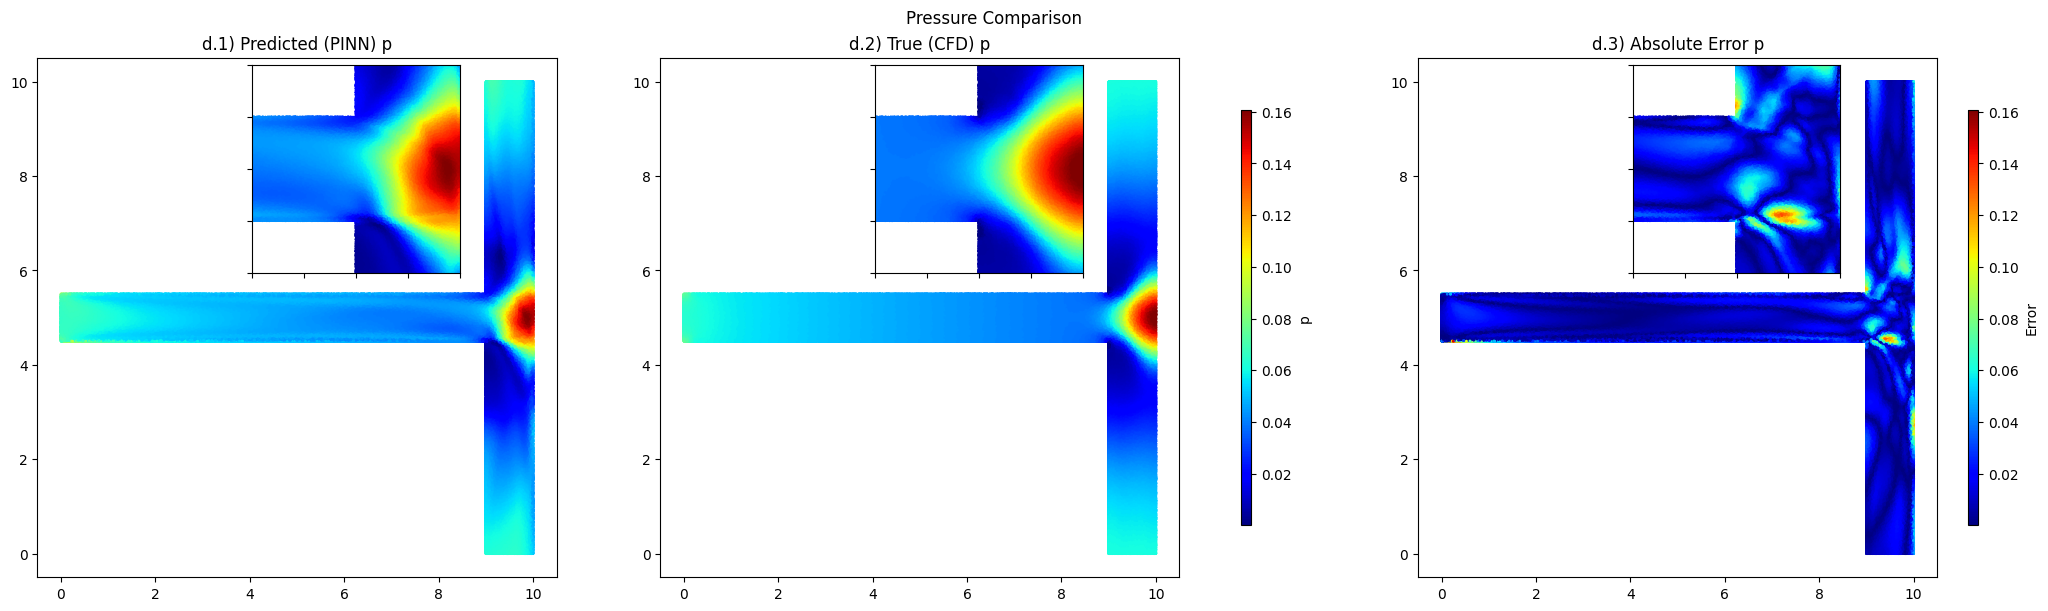

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata

# Load interior data (all available points)
[x_train_interior, y_train_interior, u_train_interior, v_train_interior, p_train_interior, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="interior-surface_body")

# Load inlet boundary data
[x_train_inlet, y_train_inlet, u_train_inlet, v_train_inlet, p_train_inlet, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="inlet")

# Load outlet 1 boundary data
[x_train_outlet1, y_train_outlet1, u_train_outlet1, v_train_outlet1, p_train_outlet1, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="outlet1")

# Load outlet 2 boundary data
[x_train_outlet2, y_train_outlet2, u_train_outlet2, v_train_outlet2, p_train_outlet2, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="outlet2")

# Load wall boundary data
[x_train_walls, y_train_walls, u_train_walls, v_train_walls, p_train_walls, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="wall-surface_body")


# --- Generation of a new high-resolution mesh within the geometry ---
num_points = 900000  # Number of high-resolution points
dense_xy = geom.random_points(num_points)  # Generate points inside the geometry

# --- PINN predictions over the dense domain ---
predictions_dense = model.predict(dense_xy)

# --- Extract predictions for u, v, and p ---
u_pred_dense = predictions_dense[:, 0]
v_pred_dense = predictions_dense[:, 1]
p_pred_dense = predictions_dense[:, 2]

# --- Denormalize the predictions using reference values ---
u_pred_denorm = u_pred_dense
v_pred_denorm = v_pred_dense
p_pred_denorm = p_pred_dense

# --- Compute the velocity magnitude ---
velocity_magnitude_pred = np.sqrt(u_pred_denorm**2 + v_pred_denorm**2)

# --- Retrieve the CFD reference values for u, v, and p ---
all_x_coords = np.concatenate([x_train_interior, x_train_inlet, x_train_outlet1, x_train_outlet2, x_train_walls], axis=0)
all_y_coords = np.concatenate([y_train_interior, y_train_inlet, y_train_outlet1, y_train_outlet2, y_train_walls], axis=0)
all_u = np.concatenate([u_train_interior, u_train_inlet, u_train_outlet1, u_train_outlet2, u_train_walls], axis=0)
all_v = np.concatenate([v_train_interior, v_train_inlet, v_train_outlet1, v_train_outlet2, v_train_walls], axis=0)
all_p = np.concatenate([p_train_interior, p_train_inlet, p_train_outlet1, p_train_outlet2, p_train_walls], axis=0)

# --- Denormalize CFD data ---
u_true_denorm = all_u.flatten()
v_true_denorm = all_v.flatten()
p_true_denorm = all_p.flatten()

# --- Interpolate CFD data onto the dense mesh ---
points_cfd = np.vstack((all_x_coords.flatten(), all_y_coords.flatten())).T  # Coordinates (x, y) from CFD data
u_true_dense = griddata(points_cfd, u_true_denorm, dense_xy, method='linear')
v_true_dense = griddata(points_cfd, v_true_denorm, dense_xy, method='linear')
p_true_dense = griddata(points_cfd, p_true_denorm, dense_xy, method='linear')

velocity_magnitude_true = np.sqrt(u_true_dense**2 + v_true_dense**2)

# --- Compute absolute errors between PINN prediction and CFD ---
error_velocity = np.abs(velocity_magnitude_pred - velocity_magnitude_true)
error_u = np.abs(u_pred_denorm - u_true_dense)
error_v = np.abs(v_pred_denorm - v_true_dense)
error_p = np.abs(p_pred_denorm - p_true_dense)

def prepare_data(x, y, pred, true, error):
    """
    Prepares the data for plotting, including optional interpolation onto a regular mesh.
    Returns the processed data to ensure that the original arrays remain unmodified.
    """
    return x, y, pred, true, error

def plot_comparison_with_internal_zoom(x, y, pred, true, error, title, component_name, vmin, vmax, vmin_err, vmax_err, index_label, zoom_region):
    """
    Plots a comparison of predicted, true, and error values for a given variable with internal zoom for detail.
    
    Args:
        x, y: Coordinates of the data points.
        pred: Predicted values from the model.
        true: Reference CFD values.
        error: Absolute error between predicted and true.
        title: Main title of the plot.
        component_name: Variable name (e.g., u, v, p).
        vmin/vmax: Limits for prediction and true plots.
        vmin_err/vmax_err: Limits for error plot.
        index_label: Label prefix (e.g., "d").
        zoom_region: Dictionary with x_min, x_max, y_min, y_max to define the zoom window.
    """
    fig, ax = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

    x, y, pred, true, error = prepare_data(x, y, pred, true, error)

    cmap = "jet"
    norm_pred_true = Normalize(vmin=vmin, vmax=vmax)
    norm_error = Normalize(vmin=vmin_err, vmax=vmax_err)

    titles = ['Predicted (PINN)', 'True (CFD)', 'Absolute Error']
    data = [pred, true, error]
    insets = []

    for i in range(3):
        sc = ax[i].scatter(x, y, c=data[i], cmap=cmap, s=1, norm=norm_pred_true if i < 2 else norm_error)
        ax[i].set_title(f"{index_label}.{i+1}) {titles[i]} {component_name}")
        ax[i].set_aspect("equal")
        
        # Create zoom inset
        insets.append(inset_axes(ax[i], width="100%", height="100%", loc='upper left',
                                 bbox_to_anchor=(0.4, 0.6, 0.4, 0.4), bbox_transform=ax[i].transAxes))
        insets[i].scatter(x, y, c=data[i], cmap=cmap, s=1, norm=norm_pred_true if i < 2 else norm_error)
        insets[i].set_xlim(zoom_region['x_min'], zoom_region['x_max'])
        insets[i].set_ylim(zoom_region['y_min'], zoom_region['y_max'])
        insets[i].set_xticklabels([])
        insets[i].set_yticklabels([])

    cbar = fig.colorbar(sc, ax=ax[:2], location="right", aspect=40, shrink=0.8, pad=0.05)
    cbar.set_label(component_name)
    cbar_error = fig.colorbar(sc, ax=ax[2], location="right", aspect=40, shrink=0.8, pad=0.05)
    cbar_error.set_label("Error")

    plt.suptitle(title)
    plt.show()

# Example calls with input data
zoom_region = {'x_min': 8.0, 'x_max': 10.0, 'y_min': 4.0, 'y_max': 6.0}

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], velocity_magnitude_pred, velocity_magnitude_true, error_velocity,
                                   "Velocity Magnitude Comparison", "Velocity Magnitude", 
                                   min(velocity_magnitude_pred.min(), velocity_magnitude_true.min()),
                                    max(velocity_magnitude_pred.max(), velocity_magnitude_true.max()),
                                    error_velocity.min(), error_velocity.max(),
                                   index_label="a", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], u_pred_denorm, u_true_dense, error_u,
                                   "U Velocity Comparison", "u", 
                                   u_pred_denorm.min(), u_pred_denorm.max(), error_u.min(), error_u.max(),
                                   index_label="b", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], v_pred_denorm, v_true_dense, error_v,
                                   "V Velocity Comparison", "v", 
                                   v_pred_denorm.min(), v_pred_denorm.max(), error_v.min(), error_v.max(),
                                   index_label="c", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], p_pred_denorm, p_true_dense, error_p,
                                   "Pressure Comparison", "p", 
                                   p_pred_denorm.min(), p_pred_denorm.max(), error_p.min(), error_p.max(),
                                   index_label="d", zoom_region=zoom_region)


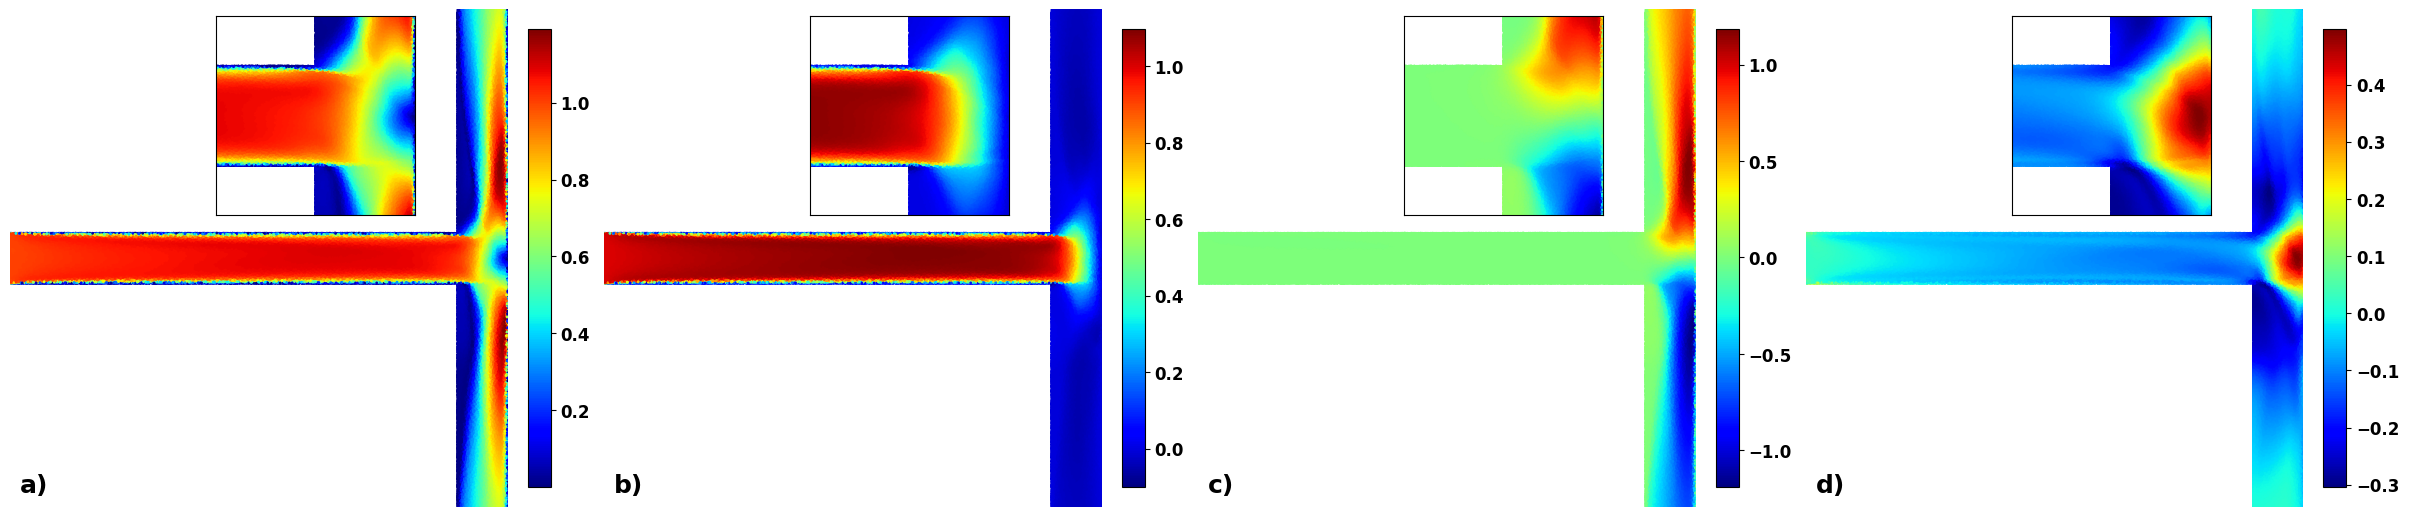

: 

In [ ]:
def plot_combined_pinn_predictions_with_insets(x, y, velocity_mag, u, v, p,
                                               vmin_list, vmax_list, zoom_region):
    """
    Plots 4 subplots (one for each PINN prediction: |v|, u, v, p) with zoom insets.
    The color scale is controlled via precomputed vmin/vmax values (no re-normalization).
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    fig, axs = plt.subplots(1, 4, figsize=(24, 6), constrained_layout=True)

    variables = [velocity_mag, u, v, p]
    labels = ["a)", "b)", "c)", "d)"]
    cmaps = ["jet"] * 4

    for i in range(4):
        norm = Normalize(vmin=vmin_list[i], vmax=vmax_list[i])
        sc = axs[i].scatter(x, y, c=variables[i], cmap=cmaps[i], s=1, norm=norm)

        axs[i].set_xlim(x.min(), x.max())
        axs[i].set_ylim(y.min(), y.max())
        axs[i].set_aspect("equal")
        axs[i].axis("off")

        # Add zoom inset
        inset_ax = inset_axes(axs[i], width="100%", height="100%", loc='upper left',
                              bbox_to_anchor=(0.4, 0.6, 0.4, 0.4), bbox_transform=axs[i].transAxes)
        inset_ax.scatter(x, y, c=variables[i], cmap=cmaps[i], s=1, norm=norm)
        inset_ax.set_xlim(zoom_region['x_min'], zoom_region['x_max'])
        inset_ax.set_ylim(zoom_region['y_min'], zoom_region['y_max'])
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])

        # Add subplot index
        axs[i].text(0.02, 0.02, labels[i], transform=axs[i].transAxes,
                    fontsize=18, fontweight='bold', verticalalignment='bottom', horizontalalignment='left')

        # Colorbar
        cbar = plt.colorbar(sc, ax=axs[i], orientation="vertical", fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=12)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontweight('bold')

    plt.show()

plot_combined_pinn_predictions_with_insets(
    x=dense_xy[:, 0],
    y=dense_xy[:, 1],
    velocity_mag=velocity_magnitude_pred,
    u=u_pred_denorm,
    v=v_pred_denorm,
    p=p_pred_denorm,
    vmin_list=[
        velocity_magnitude_pred.min(), 
        u_pred_denorm.min(), 
        v_pred_denorm.min(), 
        p_pred_denorm.min()
    ],
    vmax_list=[
        velocity_magnitude_pred.max(), 
        u_pred_denorm.max(), 
        v_pred_denorm.max(), 
        p_pred_denorm.max()
    ],
    zoom_region={'x_min': 8.0, 'x_max': 10.0, 'y_min': 4.0, 'y_max': 6.0}
)


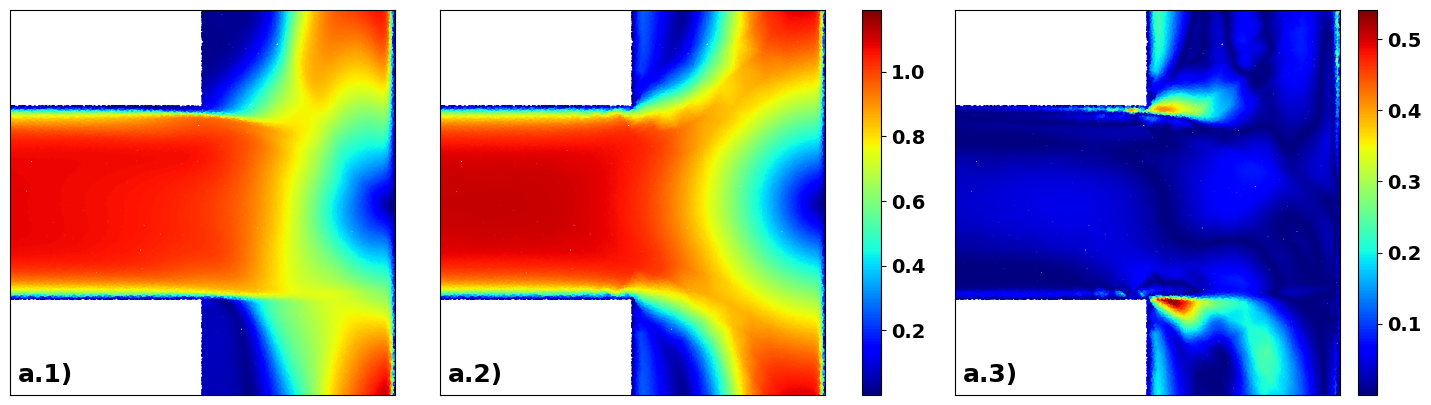

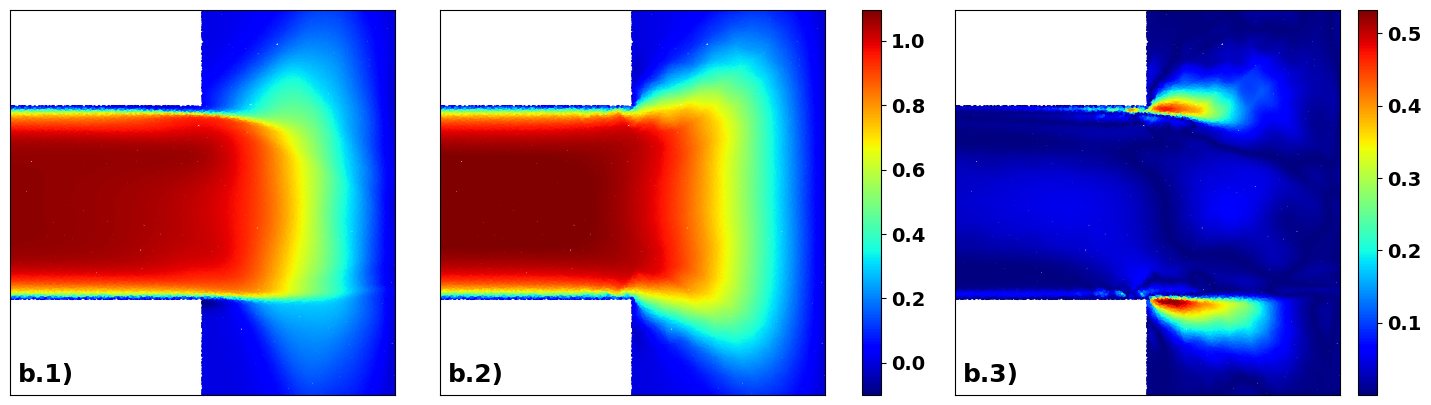

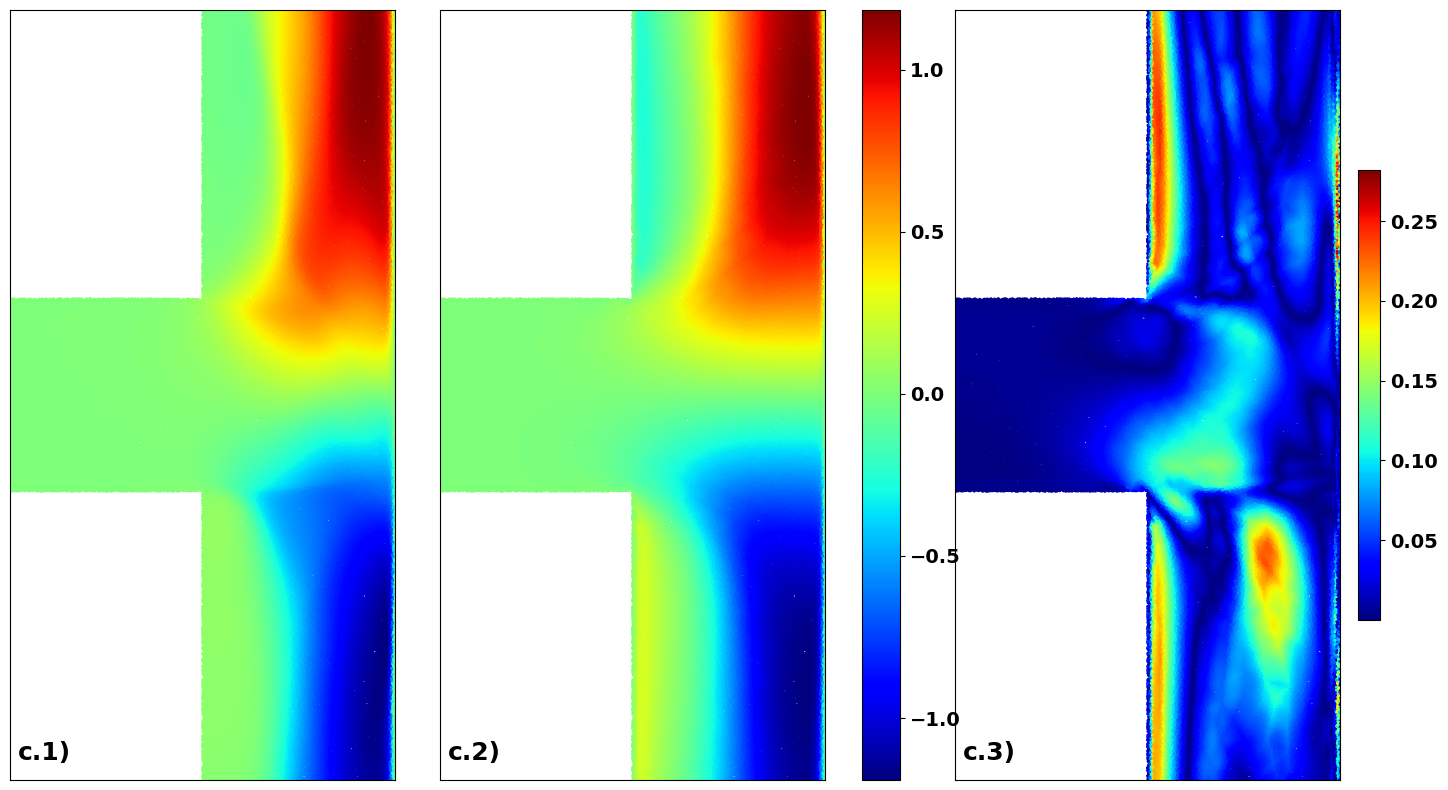

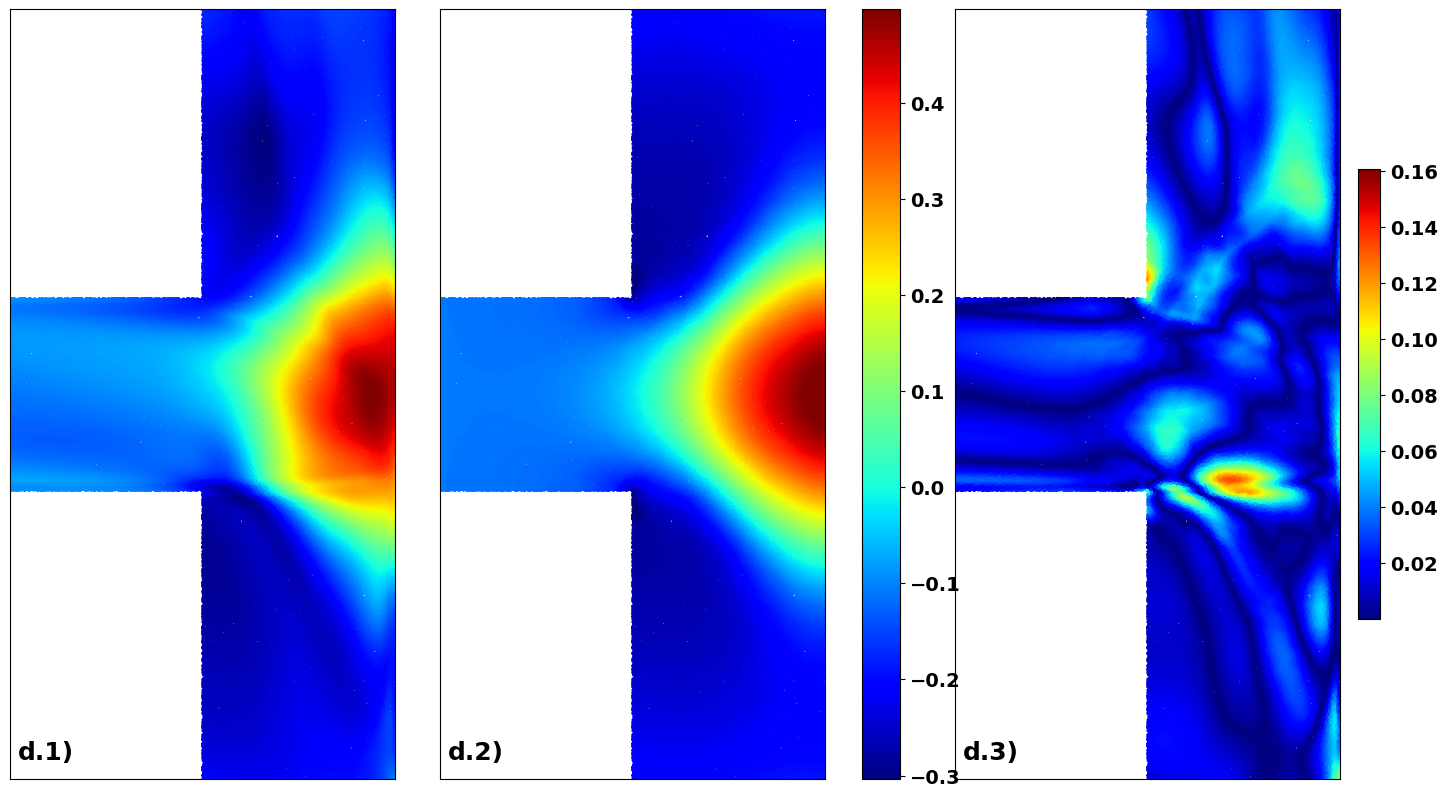

In [ ]:
def plot_internal_zoom_only(x, y, pred, true, error, component_name,
                            vmin, vmax, vmin_err, vmax_err, index_label, zoom_region, figsize=(18, 5)):
    """
    Plota zooms internos com escalas consistentes.
    Os índices, rótulos e números das barras de cores aparecem em bold e com fonte maior.
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.subplots_adjust(wspace=0.05)

    data = [pred, true, error]
    norms = [
        Normalize(vmin=vmin, vmax=vmax),
        Normalize(vmin=vmin, vmax=vmax),
        Normalize(vmin=vmin_err, vmax=vmax_err)
    ]

    cmaps = ['jet'] * 3
    sc_list = []

    for i in range(3):
        sc = axs[i].scatter(x, y, c=data[i], cmap=cmaps[i], s=1, norm=norms[i])
        axs[i].set_xlim(zoom_region['x_min'], zoom_region['x_max'])
        axs[i].set_ylim(zoom_region['y_min'], zoom_region['y_max'])
        axs[i].set_aspect('equal')
        axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # Índice em negrito
        axs[i].text(
            0.02, 0.02, f"{index_label}.{i+1})",
            transform=axs[i].transAxes,
            fontsize=18, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='left'
        )

        sc_list.append(sc)

    # Barra de cores para PINN e CFD
    cbar_shared = plt.colorbar(sc_list[0], ax=axs[:2], orientation="vertical", fraction=0.05, pad=0.04)
    cbar_shared.set_label("")
    for tick in cbar_shared.ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')

    # Barra de cores para o erro
    cbar_error = plt.colorbar(sc_list[2], ax=axs[2], orientation="vertical", fraction=0.05, pad=0.04)
    cbar_error.set_label("")
    for tick in cbar_error.ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')

    plt.show()

plot_internal_zoom_only(
    x=dense_xy[:, 0], y=dense_xy[:, 1],
    pred=velocity_magnitude_pred,
    true=velocity_magnitude_true,
    error=error_velocity,
    component_name="|v|",
    vmin=velocity_magnitude_pred.min(),
    vmax=velocity_magnitude_pred.max(),
    vmin_err=error_velocity.min(),
    vmax_err=error_velocity.max(),
    index_label="a",
    zoom_region={'x_min': 8.0, 'x_max': 10.0, 'y_min': 4.0, 'y_max': 6.0},
    figsize=(18, 5)  # horizontal (mais achatado)
)

plot_internal_zoom_only(
    x=dense_xy[:, 0], y=dense_xy[:, 1],
    pred=u_pred_denorm,
    true=u_true_dense,
    error=error_u,
    component_name="u",
    vmin=u_pred_denorm.min(),
    vmax=u_pred_denorm.max(),
    vmin_err=error_u.min(),
    vmax_err=error_u.max(),
    index_label="b",
    zoom_region={'x_min': 8.0, 'x_max': 10.0, 'y_min': 4.0, 'y_max': 6.0},
    figsize=(18, 5)
)

plot_internal_zoom_only(
    x=dense_xy[:, 0], y=dense_xy[:, 1],
    pred=v_pred_denorm,
    true=v_true_dense,
    error=error_v,
    component_name="v",
    vmin=v_pred_denorm.min(),
    vmax=v_pred_denorm.max(),
    vmin_err=error_v.min(),
    vmax_err=error_v.max(),
    index_label="c",
    zoom_region={'x_min': 8.0, 'x_max': 10.0, 'y_min': 3.0, 'y_max': 7.0},
    figsize=(18, 10)  # vertical (mais alongado)
)

plot_internal_zoom_only(
    x=dense_xy[:, 0], y=dense_xy[:, 1],
    pred=p_pred_denorm,
    true=p_true_dense,
    error=error_p,
    component_name="p",
    vmin=p_pred_denorm.min(),
    vmax=p_pred_denorm.max(),
    vmin_err=error_p.min(),
    vmax_err=error_p.max(),
    index_label="d",
    zoom_region={'x_min': 8.0, 'x_max': 10.0, 'y_min': 3.0, 'y_max': 7.0},
    figsize=(18, 10)
)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Dictionary to store results
results = {}

# Loop to compute the metrics
for true, pred, label in zip(
    [u_true_dense, v_true_dense, p_true_dense, velocity_magnitude_true],
    [u_pred_denorm, v_pred_denorm, p_pred_denorm, velocity_magnitude_pred],
    ["Velocity U", "Velocity V", "Pressure", "Velocity Magnitude"]
):
    l2_error = np.linalg.norm(true - pred) / np.linalg.norm(true)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    results[label] = {'L2 Error': l2_error, 'RMSE': rmse, 'R2': r2}

# Formatted print of the results
for variable, metrics in results.items():
    print(f"\n--- {variable} ---")
    print(f"L2 Error: {metrics['L2 Error']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"R²: {metrics['R2']:.6f}")



--- Velocity U ---
L2 Error: 0.046287
RMSE: 0.033156
R²: 0.995788

--- Velocity V ---
L2 Error: 0.094380
RMSE: 0.041361
R²: 0.991092

--- Pressure ---
L2 Error: 0.141702
RMSE: 0.018575
R²: 0.970685

--- Velocity Magnitude ---
L2 Error: 0.055238
RMSE: 0.046386
R²: 0.982901


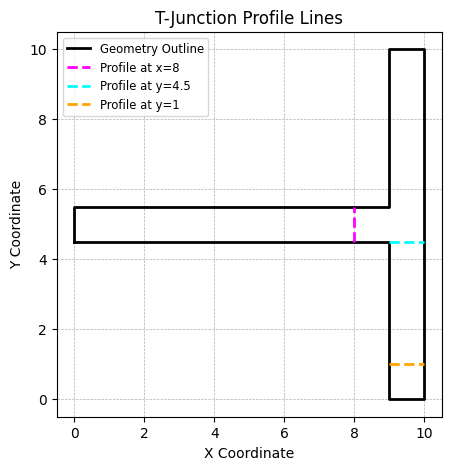

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_geometry_with_profiles(geom):
    """
    Visualize the geometry along with specific profile lines.

    Args:
        geom (Polygon): The geometry of the domain as a DeepXDE polygon.
    """
    plt.figure(figsize=(7, 5))

    # Extract polygon vertices to outline the geometry
    polygon_vertices = np.array(geom.vertices)
    polygon_vertices = np.vstack((polygon_vertices, polygon_vertices[0]))  # Close the polygon loop
    plt.plot(polygon_vertices[:, 0], polygon_vertices[:, 1], color='black', linewidth=2, label='Geometry Outline')

    # Add profile lines at predefined locations
    # Vertical profile at x = 8, from y = 4.5 to y = 5.5
    plt.plot([8, 8], [4.5, 5.5], color='magenta', linestyle='--', linewidth=2, label='Profile at x=8')

    # Horizontal profile at y = 4.5, from x = 9 to x = 10
    plt.plot([9, 10], [4.5, 4.5], color='cyan', linestyle='--', linewidth=2, label='Profile at y=4.5')

    # Horizontal profile at y = 1, from x = 9 to x = 10
    plt.plot([9, 10], [1, 1], color='orange', linestyle='--', linewidth=2, label='Profile at y=1')

    plt.title('T-Junction Profile Lines')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', fontsize='small', markerscale=1.5)
    plt.gca().set_aspect('equal', adjustable='box')  # Enforce equal aspect ratio for x and y
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Example polygon class for the T-junction (replace with your geometry)
class Polygon:
    def __init__(self, vertices):
        self.vertices = vertices

# Replace with actual geometry vertices
vertices = np.array([[0, 4.5], [0, 5.5], [9, 5.5], [9, 10], [10, 10], [10, 0], [9, 0], [9, 4.5]])
geom = Polygon(vertices)

visualize_geometry_with_profiles(geom)


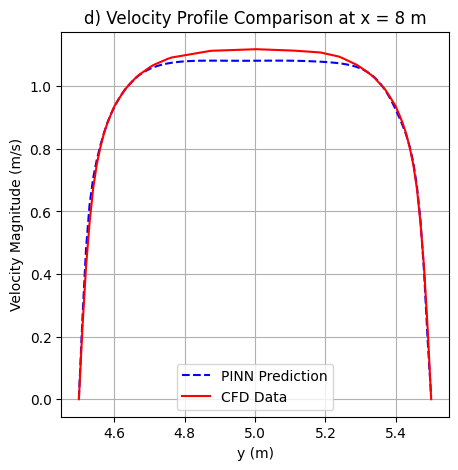

d) L2 normalized error for profile at x = 8 m: 2.35%


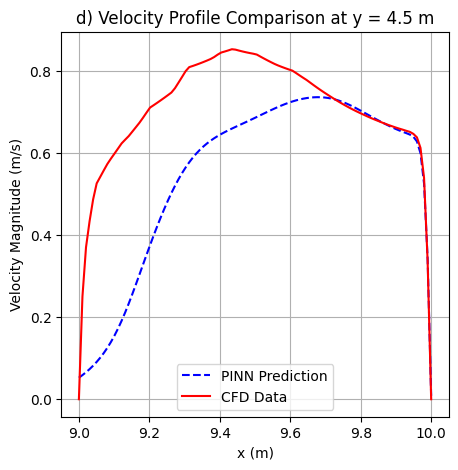

d) L2 normalized error for profile at y = 4.5 m: 30.22%


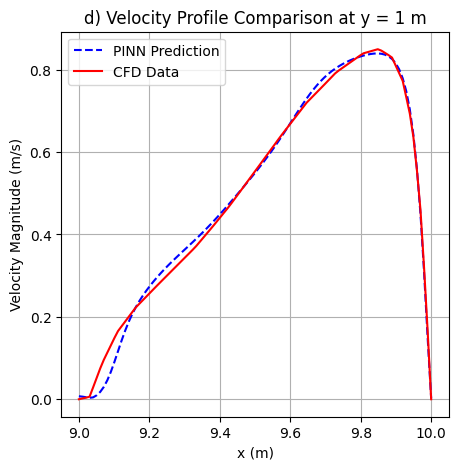

d) L2 normalized error for profile at y = 1 m: 3.47%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def compare_velocity_profiles(model, cfd_data, fixed_axis=None, fixed_value=None, variable_start=None, variable_end=None, num_points=100, index_label=""):
    """
    Compare velocity profiles between PINN and CFD along a defined line.

    Args:
        model: The trained PINN model.
        cfd_data (dict): CFD interpolated data with keys for u, v.
        fixed_axis (str): 'x' or 'y', indicating the fixed coordinate axis.
        fixed_value (float): The fixed value for the specified axis.
        variable_start (float): Start value for the varying axis.
        variable_end (float): End value for the varying axis.
        num_points (int): Number of points along the profile line.
        index_label (str): Index for labeling the plot (e.g., "a)", "b)").

    Returns:
        None. Displays a plot comparing the velocity profiles.
    """
    # Define axes based on fixed coordinate
    line_axis = np.linspace(variable_start, variable_end, num_points)
    if fixed_axis == 'x':
        line_points = np.vstack((np.full(num_points, fixed_value), line_axis)).T
        position_label = "y (m)"
    elif fixed_axis == 'y':
        line_points = np.vstack((line_axis, np.full(num_points, fixed_value))).T
        position_label = "x (m)"
    else:
        raise ValueError("The argument 'fixed_axis' must be either 'x' or 'y'.")

    # Model predictions and CFD interpolation
    predictions = model.predict(line_points)
    u_pinn = predictions[:, 0]
    v_pinn = predictions[:, 1]
    velocity_magnitude_pinn = np.sqrt(u_pinn**2 + v_pinn**2)

    cfd_points = np.vstack((cfd_data['x'], cfd_data['y'])).T
    u_cfd = griddata(cfd_points, cfd_data['u'], line_points, method='linear')
    v_cfd = griddata(cfd_points, cfd_data['v'], line_points, method='linear')
    velocity_magnitude_cfd = np.sqrt(u_cfd**2 + v_cfd**2)

    # Normalized L2 error calculation
    l2_error = (np.linalg.norm(velocity_magnitude_pinn - velocity_magnitude_cfd) /
                np.linalg.norm(velocity_magnitude_cfd)) * 100  # As percentage

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(line_axis, velocity_magnitude_pinn, label='PINN Prediction', linestyle='--', color='blue')
    plt.plot(line_axis, velocity_magnitude_cfd, label='CFD Data', linestyle='-', color='red')
    plt.title(f"{index_label} Velocity Profile Comparison at {fixed_axis} = {fixed_value} m")
    plt.xlabel(position_label)
    plt.ylabel("Velocity Magnitude (m/s)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{index_label} L2 normalized error for profile at {fixed_axis} = {fixed_value} m: {l2_error:.2f}%")

# CFD data (example; replace with actual data)
cfd_data = {
    "x": all_x_coords.flatten(),
    "y": all_y_coords.flatten(),
    "u": u_true_denorm.flatten(),
    "v": v_true_denorm.flatten(),
}

# Function calls with different profile positions
compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='x',
    fixed_value=8,
    variable_start=4.5,
    variable_end=5.5,
    num_points=100,
    index_label="d)"
)

compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='y',
    fixed_value=4.5,
    variable_start=9,
    variable_end=10,
    num_points=100,
    index_label="d)"
)

compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='y',
    fixed_value=1,
    variable_start=9,
    variable_end=10,
    num_points=100,
    index_label="d)"
)
